# Loading the model

In [1]:
# from teacher_train import FilteredLymphoMNIST, get_dataloaders
# from teacher_train import WeightedRandomSampler, balanced_weights
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from LymphoMNIST.LymphoMNIST import LymphoMNIST
from torchvision import transforms

In [2]:
import torch

# Dataset class to filter by labels
class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.labels_to_keep = labels_to_keep
        self.label_map = {label: i for i, label in enumerate(labels_to_keep)}
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        original_index = self.indices[index]
        image, label = self.original_dataset[original_index]
        return image, self.label_map[label.item()]

    def __len__(self):
        return len(self.indices)
    
    
# Function to get dataloaders
def get_dataloaders(train_ds, val_ds, split=(0.5, 0.5), batch_size=64, sampler=None, *args, **kwargs):
    lengths = [int(len(val_ds) * frac) for frac in split]
    lengths[1] += len(val_ds) - sum(lengths)  # Correct split length sum
    val_ds, test_ds = torch.utils.data.random_split(val_ds, lengths)

    shuffle = False if sampler else True
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, sampler=sampler, *args, **kwargs)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, *args, **kwargs)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, *args, **kwargs)

    return train_dl, val_dl, test_dl

# Balanced weights function for weighted sampling
def balanced_weights(dataset, nclasses):
    count = [0] * nclasses
    for _, label in dataset:
        count[label] += 1
    N = float(sum(count))
    weight_per_class = [N / float(count[i]) for i in range(nclasses)]
    return [weight_per_class[label] for _, label in dataset]


In [3]:
# our hyperparameters
params = {
    'lr': 1e-5,
    'batch_size': 16,
    'epochs': 10000,
    'model': "Teacher_final-1c",
    'im_size': 120,
}

im_size = params['im_size']

class ConvertToRGB:
    def __call__(self, tensor):
        if tensor.shape[0] == 1:
            tensor = tensor.repeat(3, 1, 1)
        return tensor
    
val_transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.4819], [0.1484]),
    ConvertToRGB()
])

In [ ]:

# Initialize dataset
original_train_ds = LymphoMNIST(root='../dataset', train=True, download=True, transform=val_transform, num_classes=3)
original_test_ds = LymphoMNIST(root='../dataset', train=False, download=True, transform=val_transform, num_classes=3)


# Specify labels to keep
labels_to_keep = [0, 2] # 0: B, 1: T4, 2: T8

# Initialize filtered dataset with labels to keep
train_ds = FilteredLymphoMNIST(original_train_ds, labels_to_keep)
test_ds= FilteredLymphoMNIST(original_test_ds, labels_to_keep)

weights = balanced_weights(train_ds, len(labels_to_keep))
sampler = WeightedRandomSampler(weights, len(weights))
# Create the dataloaders
train_dl, val_dl, test_dl = get_dataloaders(train_ds,
                                            test_ds,
                                            split=(0.5, 0.5),
                                            batch_size=params['batch_size'],
                                            sampler=sampler,
                                            num_workers=4
                                           )

In [5]:
import torch
from torchvision import models
from torch import nn

def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, len(labels_to_keep))

# Load the saved weights and map them to the correct device
# model.load_state_dict(torch.load("../checkpoint/Final_models/Teacher_imsize-120_30 September 22:37.pt", map_location=device))
model.load_state_dict(torch.load("../checkpoint/Transfer-unfreeze-faster_17 October 13:10.pt", map_location=device))

model = model.to(device)


In [6]:
def evaluate_model(model, dataloader, device):
    y_pred = []
    y_true = []

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for image, target in dataloader:
            image, target = image.to(device), target.to(device)
            outputs = model(image)
            output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction
            target = target.data.cpu().numpy()
            y_true.extend(target)  # Save target

    return y_true, y_pred

In [ ]:
from torchsummary import summary
summary(model, (3, 120, 120))

# Train vs validation accuracy

In [ ]:
test_acc = calculate_accuracy(test_dl, model, device)
print(f'Test Accuracy: {test_acc:.2f}%')


In [ ]:
test_acc = calculate_accuracy(train_dl, model, device)
print(f'Train Accuracy: {test_acc:.2f}%')


In [ ]:
test_acc = calculate_accuracy(val_dl, model, device)
print(f'Val Accuracy: {test_acc:.2f}%')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

def get_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, auroc, accuracy

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model, test_dl, device)

# Get the metrics
precision, recall, f1, auroc, accuracy = get_metrics(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUROC: {auroc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

# compare all results

In [ ]:
import matplotlib.pyplot as plt

# List of color codes
colors10 = ['#7bbbe0', '#f3df3d', '#2ba77b', '#2274b2', '#e9a001',
            '#818082', '#545253', '#8d2db1', '#d17aad', '#d4580d']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot each color as a rectangle
for i, color in enumerate(colors10):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Set axis limits and remove ticks
ax.set_xlim(0, len(colors10))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# Display the plot
plt.title('Visualization of Color Codes')
plt.show()


In [12]:
# graph values
model_accuracy = [98,94.5,90,93,97]
model_labels = ['Teacher', 'Student 1', 'Student 2', 'Transfer0', 'Transfer' ]
model_precision = [97, 94, 90, 94, 97]
model_recall= [97, 94, 89, 93, 97]
model_f1_score = [97, 94, 89, 93, 97]
model_auroc = [97, 94, 89, 94, 97]

#### pltting the bar chart

#### accuracy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

font_size=12
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

X_vals = np.array(model_accuracy)*.01
std_errors = np.array([ 0.157, 0.221, 0.342, .236, 0.221])*.01


colors4 = ['#2ba77b', '#2274b2', '#e9a001', '#545253', '#d4580d']

# Width of the bars
bar_width = 0.6

f, ax = plt.subplots(figsize=(2.1, 3.1), dpi = 100)

bars = ax.bar(model_labels, X_vals, yerr=std_errors, align='center', alpha=0.5, edgecolor='none', linewidth=0, error_kw={'elinewidth':.5}, width = bar_width, capsize=3)

ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')
ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')

print(len(bars))
for i, bar in enumerate(bars):
    bar.set_color(colors4[i])

# ax.set_ylabel('Precission (\%)')
ax.title.set_text('Accuracy')  
plt.yticks( fontsize = 12)
plt.xticks(rotation=90, fontsize = 12)
plt.ylim([.8, 1])

image_name = "accuracy"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')


### precision

5


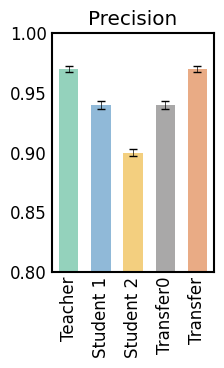

In [3]:
import matplotlib.pyplot as plt
import numpy as np

font_size=12
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

X_vals = np.array(model_precision)*.01
std_errors = np.array([0.221, 0.342, 0.266, 0.314, 0.266])*.01


colors4 = ['#2ba77b', '#2274b2', '#e9a001', '#545253', '#d4580d']

# Width of the bars
bar_width = 0.6

f, ax = plt.subplots(figsize=(2.1, 3.1), dpi = 100)

bars = ax.bar(model_labels, X_vals, yerr=std_errors, align='center', alpha=0.5, edgecolor='none', linewidth=0, error_kw={'elinewidth':.5}, width = bar_width, capsize=3)

ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')
ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')

print(len(bars))
for i, bar in enumerate(bars):
    bar.set_color(colors4[i])

# ax.set_ylabel('Precission (\%)')
ax.title.set_text('Precision')  
plt.yticks( fontsize = 12)
plt.xticks(rotation=90, fontsize = 12)
plt.ylim([.8, 1])

image_name = "precision"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')


#### recall

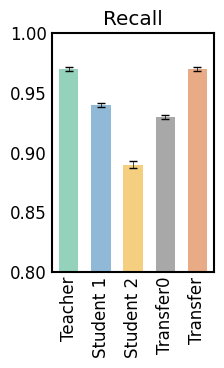

In [6]:
import matplotlib.pyplot as plt
import numpy as np

font_size=12
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50


X_vals = np.array(model_recall)*.01
std_errors = np.array([0.166, 0.177, 0.32,  0.157,  0.177])*.01

colors4 = ['#2ba77b', '#2274b2', '#e9a001', '#545253', '#d4580d']

# Width of the bars
bar_width = 0.6

f, ax = plt.subplots(figsize=(2.1, 3.1), dpi = 100)

bars = ax.bar(model_labels, X_vals, yerr=std_errors, align='center', alpha=0.5, 
              edgecolor='none', linewidth=0, error_kw={'elinewidth':.5}, width = bar_width, capsize=3)

ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')
ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')

for i, bar in enumerate(bars):
    bar.set_color(colors4[i])

ax.title.set_text('Recall') 
plt.yticks( fontsize = 12)
plt.xticks(rotation=90, fontsize = 12)
plt.ylim([.80, 1])

image_name = "recall"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')

#### F1 -score

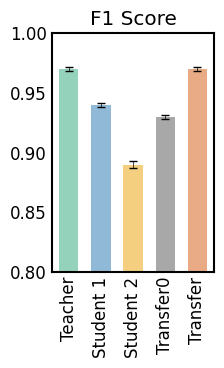

In [9]:
import matplotlib.pyplot as plt
import numpy as np

font_size=12
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

X_vals = np.array(model_f1_score)*.01
std_errors = np.array([0.166, 0.177, 0.32,  0.157, 0.177])*.01


colors4 = ['#2ba77b', '#2274b2', '#e9a001', '#545253', '#d4580d']

# Width of the bars
bar_width = 0.6

f, ax = plt.subplots(figsize=(2.1, 3.1), dpi = 100)

bars = ax.bar(model_labels, X_vals, yerr=std_errors, align='center', alpha=0.5, 
              edgecolor='none', linewidth=0, error_kw={'elinewidth':.5}, width = bar_width, capsize=3)

ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')
ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')

for i, bar in enumerate(bars):
    bar.set_color(colors4[i])

ax.title.set_text('F1 Score') 
plt.yticks( fontsize = 12)
plt.xticks(rotation=90, fontsize = 12)
plt.ylim([.80, 1])


image_name = "f1_score"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')

#### AUROC

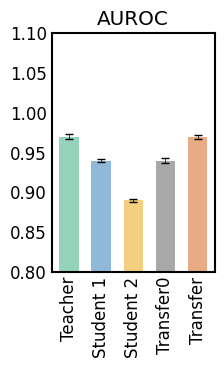

In [14]:
import matplotlib.pyplot as plt
import numpy as np

font_size=12
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

X_vals = np.array(model_auroc)*.01
std_errors = np.array([ 0.32,  0.157, 0.221, 0.342, 0.221])*.01


colors4 = ['#2ba77b', '#2274b2', '#e9a001', '#545253', '#d4580d']

# Width of the bars
bar_width = 0.6

f, ax = plt.subplots(figsize=(2.1, 3.1), dpi = 100)

bars = ax.bar(model_labels, X_vals, yerr=std_errors, align='center', alpha=0.5, 
              edgecolor='none', linewidth=0, error_kw={'elinewidth':.5}, width = bar_width, capsize=3)

ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')
ax.tick_params(axis='both', length=10, width=0.0, color= 'gray', direction='in')

for i, bar in enumerate(bars):
    bar.set_color(colors4[i])

ax.title.set_text('AUROC') 
# plt.yticks( fontsize = 12)
plt.xticks(rotation=90)
plt.ylim([.80, 1.1])


image_name = "auroc"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')